<a href="https://colab.research.google.com/github/mallakhanyy/AGENCY.gihub.io/blob/main/FaceRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mtcnn
!pip install opendatasets
!pip install keras-facenet

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/yasserh/avengers-faces-dataset')

Skipping, found downloaded files in "./avengers-faces-dataset" (use force=True to force download)


In [4]:
from mtcnn.mtcnn import MTCNN
import cv2 as cv
import numpy as np
from numpy import savez_compressed, asarray
import os
import matplotlib.pyplot as plt
from PIL import Image
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import pickle

In [5]:
# Extract single face from image
detector = MTCNN()
def extract_face(filename, required_size=(160,160)):
  image = Image.open(filename).convert('RGB')
  pixels = asarray(image)
  results = detector.detect_faces(pixels)
  if len(results) == 0:
    return None
  x1, y1, width, height = results[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  face = pixels[y1:y2, x1:x2]
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
No face detected in: chris_evans3.png
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)
15 (160, 160, 3)
16 (160, 160, 3)
17 (160, 160, 3)
18 (160, 160, 3)
19 (160, 160, 3)
20 (160, 160, 3)
21 (160, 160, 3)
22 (160, 160, 3)
23 (160, 160, 3)
24 (160, 160, 3)
25 (160, 160, 3)
26 (160, 160, 3)
27 (160, 160, 3)
28 (160, 160, 3)
29 (160, 160, 3)
30 (160, 160, 3)
31 (160, 160, 3)
32 (160, 160, 3)
33 (160, 160, 3)
34 (160, 160, 3)
35 (160, 160, 3)
36 (160, 160, 3)
37 (160, 160, 3)
38 (160, 160, 3)
39 (160, 160, 3)
40 (160, 160, 3)
41 (160, 160, 3)
42 (160, 160, 3)
43 (160, 160, 3)
44 (160, 160, 3)
45 (160, 160, 3)
46 (160, 160, 3)
47 (160, 160, 3)
48 (160, 160, 3)
49 (160, 160, 3)


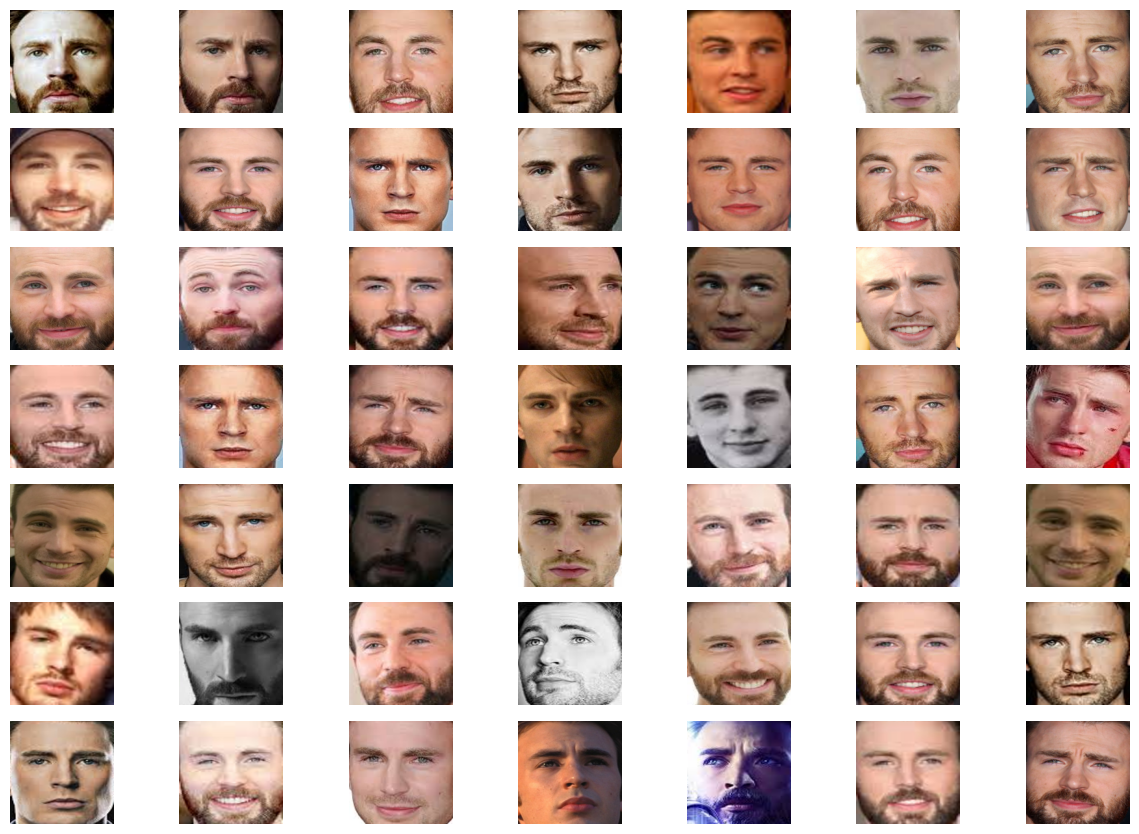

In [6]:
folder = "/content/avengers-faces-dataset/images/train/chris_evans"
i = 1  # subplot index

plt.figure(figsize=(12, 12))  # Adjust the figure size as needed

for filename in os.listdir(folder):
    path = os.path.join(folder, filename)
    face = extract_face(path)

    if face is not None:
        print(i, face.shape)
        plt.subplot(10, 7, i)
        plt.axis('off')
        plt.imshow(face)
        i += 1
    else:
        print(f"No face detected in: {filename}")

    if i > 70:  # 10 rows x 7 columns
        break

plt.tight_layout()
plt.show()


In [7]:
def load_faces(directory):
  faces = list()
  for filename in os.listdir(directory):
    path = directory + "/" + filename
    face = extract_face(path) # the previous function
    if face is not None:
      faces.append(face)
  return faces

In [8]:
def load_dataset(directory):
  x, y = list(), list()
  for subdir in os.listdir(directory):
    path = directory + "/" + subdir
    if not os.path.isdir(path):
      continue
    faces = load_faces(path) #the previous function
    if len(faces) == 0:
      continue
    labels = [subdir for _ in range(len(faces))]
    print(f"Loaded {len(faces)} examples for class: {subdir}")
    x.extend(faces)
    y.extend(labels)
  return asarray(x), asarray(y)

In [9]:
trainFolder = "/content/avengers-faces-dataset/images/train"
testFolder = "/content/avengers-faces-dataset/images/test"
trainX, trainY = load_dataset(trainFolder)
print(f"Train shape: {trainX.shape} <> {trainY.shape}")
testX, testY = load_dataset(testFolder)
print(f"Test shape: {testX.shape} <> {testY.shape}")
savez_compressed("avengers_faces_dataset.npz", trainX, trainY, testX, testY)

Loaded 51 examples for class: robert_downey_jr
Loaded 49 examples for class: chris_evans
Loaded 53 examples for class: chris_hemsworth
Loaded 54 examples for class: scarlett_johansson
Loaded 66 examples for class: mark_ruffalo
Train shape: (273, 160, 160, 3) <> (273,)
Loaded 12 examples for class: robert_downey_jr
Loaded 12 examples for class: chris_evans
Loaded 12 examples for class: chris_hemsworth
Loaded 12 examples for class: scarlett_johansson
Loaded 12 examples for class: mark_ruffalo
Test shape: (60, 160, 160, 3) <> (60,)


In [10]:
data = np.load("avengers_faces_dataset.npz")
trainX, trainY, testX, testY = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print(f"Loaded Train: {trainX.shape}, {trainY.shape}  Loaded Test: {testX.shape}, {testY.shape}")

Loaded Train: (273, 160, 160, 3), (273,)  Loaded Test: (60, 160, 160, 3), (60,)


In [11]:
# Extract face embeddings
embedder = FaceNet()
def get_embedding(face_pixels):
  face_pixels = face_pixels.astype("float32")
  samples = np.expand_dims(face_pixels, axis=0)
  yhat = embedder.embeddings(samples)
  return yhat[0]

In [12]:
def embedding(x):
  EMBEDDED_X = []
  for img in x:
      emb = get_embedding(img)
      if emb is not None:
          EMBEDDED_X.append(emb)
  EMBEDDED_X = np.asarray(EMBEDDED_X)
  return EMBEDDED_X

In [13]:
EMBEDDED_X = embedding(trainX)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [14]:
# Normalize face embedding vector
inEncoder = Normalizer(norm="l2")
EMBEDDED_X = inEncoder.transform(EMBEDDED_X)

In [15]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(trainY)

In [16]:
model = SVC(kernel='linear', probability=True)
model.fit(EMBEDDED_X, y_encoded)

SVC(kernel='linear', probability=True)

In [17]:
accuracy = model.score(EMBEDDED_X, y_encoded)
print(f"Training accuracy: {accuracy:.2%}")

Training accuracy: 100.00%


In [18]:
# Save Model
with open('svm_face_recognition.pkl', 'wb') as f:
    pickle.dump((model, label_encoder), f)

In [25]:
EMBEDDED_X_test = embedding(testX)
y_test_encoded = label_encoder.transform(testY)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
with open('svm_face_recognition.pkl', 'rb') as file:
    model, label_encoder = pickle.load(file)

In [27]:
y_hat_test = model.predict(EMBEDDED_X_test)

In [28]:
acc = accuracy_score(y_test_encoded, y_hat_test)
print(f"Test Accuracy: {acc:.2%}\n")

Test Accuracy: 100.00%



In [29]:
print("Classification Report:\n", classification_report(y_test_encoded, y_hat_test, target_names=label_encoder.classes_))

Classification Report:
                     precision    recall  f1-score   support

       chris_evans       1.00      1.00      1.00        12
   chris_hemsworth       1.00      1.00      1.00        12
      mark_ruffalo       1.00      1.00      1.00        12
  robert_downey_jr       1.00      1.00      1.00        12
scarlett_johansson       1.00      1.00      1.00        12

          accuracy                           1.00        60
         macro avg       1.00      1.00      1.00        60
      weighted avg       1.00      1.00      1.00        60



In [30]:
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_hat_test))

Confusion Matrix:
 [[12  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0 12]]
